In [81]:
from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt

In [82]:
wandb.init()
config = wandb.config

config.max_len = 11
config.buckets = 20

# Save data to array file first
save_data_to_array(max_len=config.max_len, n_mfcc=config.buckets)

labels=np.array(["bus", "car_horn", "chainsaw", "cow", "engine", "footsteps", 
                 "hand_saw", "hen", "NO", "rooster", "siren", "train"])

Saving vectors of label - 'train': 100%|███████████████████████████████████████████████| 40/40 [00:00<00:00, 55.86it/s]


In [83]:
# Loading train/test set
X_train, X_test, y_train, y_test = get_train_test()

In [84]:
# Setting channels to 1 to generalize stereo sound to 1 channel
channels = 1
config.epochs = 50
config.batch_size = 100

# Number of classes
num_classes = 12

# Reshape X_train and X_test to include a 4th dimension (channels)
X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len, channels)
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len, channels)

0.0


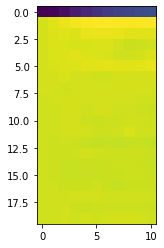

In [85]:
# Spectrogram visualized of 0th element
plt.imshow(X_train[1, :, :, 0])
print(y_train[1])

In [86]:
# Getting vector number where each number corresponds to a label
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [87]:
# Building the model
model = Sequential()

# Conv2D: 
#    Filters: 32
#    Kernel_size: (3,3) (height/width of the 2D convolution window)     
model.add(Conv2D(32, (3, 3),
    input_shape=(config.buckets, config.max_len, channels),
    activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [88]:
# Configure CNN for training
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [89]:
wandb.init()
print(y_train_hot.shape)
print(labels.shape)
print(X_train.shape)
# Train the CNN model
#    X_train: Input data
#    y_train_hot: Target data
model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot), callbacks=[WandbCallback(data_type="image", labels=labels)])

(786, 12)
(12,)
(786, 20, 11, 1)
Train on 786 samples, validate on 525 samples
Epoch 1/50
786/786 [==============================] - ETA: 13s - loss: 29.4236 - accuracy: 0.06 - ETA: 4s - loss: 17.5163 - accuracy: 0.2292 - ETA: 2s - loss: 14.0416 - accuracy: 0.418 - ETA: 1s - loss: 13.7337 - accuracy: 0.450 - ETA: 0s - loss: 11.7105 - accuracy: 0.417 - ETA: 0s - loss: 10.6337 - accuracy: 0.419 - ETA: 0s - loss: 9.0447 - accuracy: 0.456 - ETA: 0s - loss: 8.5119 - accuracy: 0.48 - ETA: 0s - loss: 8.1074 - accuracy: 0.49 - 1s 2ms/step - loss: 7.4717 - accuracy: 0.5038 - val_loss: 3.6153 - val_accuracy: 0.3086
Epoch 2/50
786/786 [==============================] - ETA: 0s - loss: 2.2081 - accuracy: 0.40 - ETA: 0s - loss: 2.7737 - accuracy: 0.38 - ETA: 0s - loss: 2.6876 - accuracy: 0.47 - ETA: 0s - loss: 2.6280 - accuracy: 0.54 - ETA: 0s - loss: 2.5611 - accuracy: 0.53 - ETA: 0s - loss: 2.5760 - accuracy: 0.51 - ETA: 0s - loss: 2.4361 - accuracy: 0.52 - ETA: 0s - loss: 2.3926 - accuracy: 0.52

786/786 [==============================] - ETA: 0s - loss: 0.3109 - accuracy: 0.90 - ETA: 0s - loss: 0.2602 - accuracy: 0.93 - ETA: 1s - loss: 0.2926 - accuracy: 0.93 - ETA: 1s - loss: 0.4282 - accuracy: 0.89 - ETA: 1s - loss: 0.4326 - accuracy: 0.88 - ETA: 1s - loss: 0.4904 - accuracy: 0.87 - ETA: 0s - loss: 0.4707 - accuracy: 0.87 - ETA: 0s - loss: 0.4597 - accuracy: 0.87 - ETA: 0s - loss: 0.4517 - accuracy: 0.86 - ETA: 0s - loss: 0.4349 - accuracy: 0.87 - ETA: 0s - loss: 0.4330 - accuracy: 0.87 - ETA: 0s - loss: 0.4386 - accuracy: 0.86 - 1s 1ms/step - loss: 0.4327 - accuracy: 0.8639 - val_loss: 1.6377 - val_accuracy: 0.6438
Epoch 15/50
786/786 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.87 - ETA: 0s - loss: 0.3819 - accuracy: 0.88 - ETA: 0s - loss: 0.3861 - accuracy: 0.87 - ETA: 0s - loss: 0.3420 - accuracy: 0.88 - ETA: 0s - loss: 0.3651 - accuracy: 0.88 - ETA: 0s - loss: 0.3857 - accuracy: 0.87 - 0s 525us/step - loss: 0.3898 - accuracy: 0.8791 - val_loss

786/786 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 1.00 - ETA: 0s - loss: 0.1286 - accuracy: 0.96 - ETA: 0s - loss: 0.1452 - accuracy: 0.96 - ETA: 0s - loss: 0.1332 - accuracy: 0.96 - ETA: 0s - loss: 0.1255 - accuracy: 0.97 - ETA: 0s - loss: 0.1447 - accuracy: 0.96 - ETA: 0s - loss: 0.1410 - accuracy: 0.96 - ETA: 0s - loss: 0.1363 - accuracy: 0.96 - ETA: 0s - loss: 0.1419 - accuracy: 0.96 - ETA: 0s - loss: 0.1393 - accuracy: 0.96 - ETA: 0s - loss: 0.1424 - accuracy: 0.96 - ETA: 0s - loss: 0.1417 - accuracy: 0.96 - ETA: 0s - loss: 0.1503 - accuracy: 0.96 - ETA: 0s - loss: 0.1454 - accuracy: 0.96 - ETA: 0s - loss: 0.1438 - accuracy: 0.96 - ETA: 0s - loss: 0.1373 - accuracy: 0.96 - 1s 1ms/step - loss: 0.1373 - accuracy: 0.9669 - val_loss: 2.1952 - val_accuracy: 0.6152
Epoch 30/50
786/786 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.97 - ETA: 0s - loss: 0.1181 - accuracy: 0.96 - ETA: 0s - loss: 

786/786 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.96 - ETA: 0s - loss: 0.0651 - accuracy: 0.98 - ETA: 0s - loss: 0.0554 - accuracy: 0.98 - ETA: 0s - loss: 0.0732 - accuracy: 0.98 - ETA: 0s - loss: 0.0922 - accuracy: 0.97 - ETA: 0s - loss: 0.0795 - accuracy: 0.98 - ETA: 0s - loss: 0.0947 - accuracy: 0.98 - ETA: 0s - loss: 0.0963 - accuracy: 0.97 - ETA: 0s - loss: 0.1047 - accuracy: 0.97 - 1s 782us/step - loss: 0.1000 - accuracy: 0.9796 - val_loss: 2.4679 - val_accuracy: 0.6248
Epoch 42/50
786/786 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.96 - ETA: 0s - loss: 0.0942 - accuracy: 0.98 - ETA: 0s - loss: 0.0742 - accuracy: 0.98 - ETA: 0s - loss: 0.0639 - accuracy: 0.98 - ETA: 0s - loss: 0.0658 - accuracy: 0.98 - ETA: 0s - loss: 0.0722 - accuracy: 0.98 - 0s 469us/step - loss: 0.0726 - accuracy: 0.9809 - val_loss: 2.4397 - val_accuracy: 0.6400
Epoch 43/50
786/786 [==============================] - ETA: 1s - loss: 0.1071 - accuracy: 0.

In [90]:
# Save the keras model
model.save("ant_cnn_model.h5")
print("Model has been saved.")

Model has been saved.


## Running the IntelliChirp Biophony CNN

In [91]:
from keras.models import load_model

# Load the model
loaded_model = load_model('ant_cnn_model.h5')

In [92]:
# Summarize the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 18, 9, 32)         320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 4, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               147584    
_________________________________________________________________
dense_8 (Dense)              (None, 12)                1548      
Total params: 149,452
Trainable params: 149,452
Non-trainable params: 0
_________________________________________________________________


In [93]:
## Running the model

n_mfcc = 20
max_len = 11
# convert file to wav2mfcc
# Mel-frequency cepstral coefficients
file_path = "./prediction/nature_sc.wav"
big_wave, sr = librosa.load(file_path, mono=True, sr=None)
#print(wave.shape, sr)

classification = []

for sec_index in range( int(big_wave.shape[0] / sr) ) :
    start_sec = sec_index
    end_sec = sec_index + 1
    
    sec_to_trim = np.array( [ float(start_sec), float(end_sec) ] )
    print(sec_to_trim)
    sec_to_trim = np.ceil( sec_to_trim * sr )

    wave = big_wave[int(sec_to_trim[0]) : int(sec_to_trim[1])]
    print(wave)

    wave = np.asfortranarray(wave[::3])
    mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=n_mfcc)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]

    # Convert wav to MFCC
    prediction_data = wav2mfcc('./prediction/nature_sc.wav')
    prediction_data = mfcc
    print(prediction_data.shape)
    #print(wav2mfcc())
    # Reshape to 4 dimensions
    prediction_data = prediction_data.reshape(1, config.buckets, config.max_len, channels)
    prediction_data = prediction_data.reshape(1, 20, config.max_len, channels)

    # Run the model on the inputted file
    predicted = loaded_model.predict(prediction_data)

    # Output the prediction values for each class
    print ('PREDICTED VALUES')
    labels_indices = range(len(labels))
    max_value = 0
    max_value_index = 0
    for index in labels_indices:
        print('\n', labels[index], ": ", '%.08f' % predicted[0,index])
        if predicted[0,index] > max_value:
            max_value_index = index
            max_value = predicted[0,index]

    # Output the prediction
    if max_value < 0.5:
        print("GUESS: Nothing")
        classification.append( { "class" : "Nothing", "timestamp" : start_sec } )
    else:
        print('\n\nGUESS: ', labels[max_value_index])
        classification.append( { "class" : labels[max_value_index], "timestamp" : start_sec } )

print(classification)

[0. 1.]
[ 0.0000000e+00  1.5258789e-05  0.0000000e+00 ...  3.3020020e-02
  1.2680054e-02 -8.7432861e-03]
(20, 11)
PREDICTED VALUES

 bus :  0.92256606

 car_horn :  0.00708957

 chainsaw :  0.00023023

 cow :  0.00000893

 engine :  0.05298990

 footsteps :  0.00000708

 hand_saw :  0.00001397

 hen :  0.00001917

 NO :  0.01487112

 rooster :  0.00019682

 siren :  0.00198627

 train :  0.00002100


GUESS:  bus
[1. 2.]
[-0.03717041 -0.05769348 -0.06455994 ...  0.01766968  0.01895142
  0.01779175]
(20, 11)
PREDICTED VALUES

 bus :  0.00028069

 car_horn :  0.05699804

 chainsaw :  0.00018920

 cow :  0.00000000

 engine :  0.00147431

 footsteps :  0.00000000

 hand_saw :  0.00000008

 hen :  0.00000955

 NO :  0.94104111

 rooster :  0.00000046

 siren :  0.00000643

 train :  0.00000008


GUESS:  NO
[2. 3.]
[ 0.02345276  0.02101135  0.01712036 ... -0.01161194 -0.0141449
 -0.01431274]
(20, 11)
PREDICTED VALUES

 bus :  0.97347200

 car_horn :  0.00168873

 chainsaw :  0.00091644

 cow

 chainsaw :  0.33492047

 cow :  0.00439450

 engine :  0.49836564

 footsteps :  0.00002991

 hand_saw :  0.00154657

 hen :  0.00006111

 NO :  0.15331613

 rooster :  0.00019618

 siren :  0.00001620

 train :  0.00001282
GUESS: Nothing
[21. 22.]
[ 0.09413147  0.07905579  0.05625916 ... -0.01145935 -0.00245667
  0.00479126]
(20, 11)
PREDICTED VALUES

 bus :  0.05381463

 car_horn :  0.11568055

 chainsaw :  0.05711745

 cow :  0.00124395

 engine :  0.61175799

 footsteps :  0.00027811

 hand_saw :  0.00994575

 hen :  0.00036368

 NO :  0.12229222

 rooster :  0.00040235

 siren :  0.00118459

 train :  0.02591871


GUESS:  engine
[22. 23.]
[ 0.0037384   0.01168823  0.01628113 ... -0.03440857 -0.05511475
 -0.08209229]
(20, 11)
PREDICTED VALUES

 bus :  0.11844277

 car_horn :  0.00051353

 chainsaw :  0.13748977

 cow :  0.10302880

 engine :  0.05113287

 footsteps :  0.00163282

 hand_saw :  0.00338257

 hen :  0.00145527

 NO :  0.57984030

 rooster :  0.00070481

 siren :  0.00